In [313]:
import matplotlib.pyplot as plt

dates = ['20120411', '20160413', '20200415', '20240410']

In [314]:
# 0: 극우
# 1: 보수
# 2: 중도
# 3: 진보
# 4: 극좌

def party_to_spectrum(date, party, city, name):
    f = open(f'election_change\\{date}-party.csv', 'r', encoding='UTF-8')
    result = []
    for line in f:
        line = line.split(',')

        if line[0] == party:
            if party != '무소속':
                result = list(map(int, line[3:]))
                break
            elif line[1] == city and line[2] == name:
                result = list(map(int, line[3:]))
                break
    
    f.close()
    return result

def get_party_color(spectrums: list[int]):
    if len(spectrums) == 0:
        return (0.5, 0.5, 0.5)
    colors = [(1, 0, 0), (1, 0, 0), (0, 1, 0), (0, 0, 1), (1, 1, 0)]
    return colors[spectrums[0]]

In [315]:
def get_prev_district(date, city, district_name):
    prev_file = open(f'election_change\\{date}-district.csv', 'r')

    prev_city = city
    if date == '20240410':
        if city == '강원특별자치도':
            prev_city = '강원도'
        elif city == '전북특별자치도':
            prev_city = '전라북도'
        
    for line in prev_file:
        line = line.split(',')

        if line[0] == city and line[1] == district_name:
            result = []
            i = 2
            
            while i < len(line):
                if date == '20240410' and line[i] == '군위군의성군청송군영덕군':
                    prev_city = '경상북도'
                        
                result.append((prev_city, line[i], int(line[i + 1])))
                i += 2
            return result
        
    return [(prev_city, district_name, 1)]

In [316]:
data = []

for date in dates:
    election_file = open(f'election_data\\{date}-district.csv', 'r')
    election_data = {}

    for line in election_file:
        row = {}

        line = line.split(',')
        city = line[0]
        district_name = line[1].strip()

        if city not in election_data.keys():
            election_data[city] = {}

        idx = 2
        results = []

        while idx < len(line):
            party, name, votes = line[idx:idx+3]
            votes = float(votes)

            results.append((party, name, votes))
            idx += 3
            
        election_data[city][district_name] = results
        if date == dates[0]:
            continue

    data.append(election_data)

In [317]:
def predict_prev_election(i, city, district_name):
    date = dates[i]
    curr_data = data[i][city][district_name]

    prev_date = dates[i - 1]
    prev_districts = get_prev_district(date, city, district_name)

    # Get amount of votes that each spectrum got
    bucket = [0 for _ in range(5)]
    for (prev_city, prev_district, weight) in prev_districts:
        for (party, name, votes) in data[i - 1][prev_city][prev_district]:
            spectrums = party_to_spectrum(prev_date, party, prev_city, name)
            for s in spectrums:
                bucket[s] += weight * votes / len(spectrums)
    
    # Calculate how is the vote is going to be distributed, based on spectrum
    vote_dist = [[] for _ in range(5)]
    for candidate, (party, name, votes) in enumerate(curr_data):
        spectrums = party_to_spectrum(date, party, city, name)
        for s in spectrums:
            vote_dist[s].append((candidate, 1 / len(spectrums)))

    # Distribute the votes from the previous result to the result
    vote_prediction = [0 for _ in curr_data]
    for s, dist_list in enumerate(vote_dist):
        weight_sum = sum(map(lambda x: x[1], dist_list))
        for (candidate, weight) in dist_list:
            vote_prediction[candidate] += weight / weight_sum * bucket[s]

    # Normalize the sum
    vote_sum = sum(vote_prediction)
    for n in range(len(vote_prediction)):
        vote_prediction[n] /= vote_sum / 100

    result = []
    for candidate, (party, name, votes) in enumerate(curr_data):
        prediction = vote_prediction[candidate]
        result.append((party, name, prediction))
    
    return result

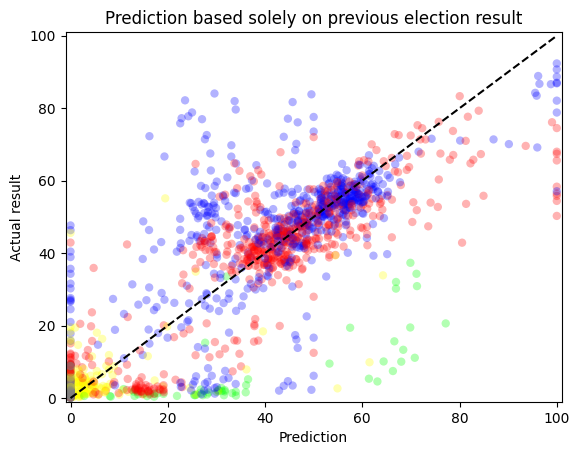

In [318]:
X = []
Y = []
colors = []
for i, date in enumerate(dates[2:]):
    i = i + 2
    for city in data[i].keys():
        for district_name in data[i][city].keys():
            prediction = predict_prev_election(i, city, district_name)
            result = data[i][city][district_name]

            colors.extend(map(lambda x: get_party_color(party_to_spectrum(date, x[0], city, x[1])), result))
            X.extend(map(lambda x: x[2], prediction))
            Y.extend(map(lambda x: x[2], result))

line = [x for x in range(101)]

plt.xlim(-1, 101)
plt.ylim(-1, 101)
plt.title('Prediction Based on Previous Election Result')
plt.xlabel('Prediction')
plt.ylabel('Actual result')

plt.plot((0, 100), (0, 100), 'k--')
plt.scatter(X, Y, c=colors, alpha=0.3, edgecolors='none')